In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas
import xarray
import h5py

from matplotlib import pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import root_scalar

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import kinematics
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting

In [2]:
os.getenv('ENDPOINT_URL') 

tbl_file = 's3://llc/Tables/test_noise_modis2012.parquet'
llc_table = ulmo_io.load_main_table(tbl_file)

# for later use
llc_table['DT_abs'] = llc_table.Tmax - llc_table.Tmin

Read main table: s3://llc/Tables/test_noise_modis2012.parquet


In [3]:
ds1 = xarray.load_dataset( ulmo_io.open( 's3://llc/CC/LLC_CC_mask_64.nc', 'rb') )

KeyboardInterrupt: 

# Grab one random cutout

In [3]:
cutout = llc_table.iloc[2500]
cutout

modis_lat                                                  -19.198042
modis_lon                                                  112.943794
modis_col                                                         709
modis_datetime                                    2012-01-02 17:55:00
modis_LL                                                   396.755859
modis_row                                                         176
clear_fraction                                               0.003845
mean_temperature                                            26.703159
Tmin                                                        25.734001
Tmax                                                           27.541
T90                                                         27.015001
T10                                                            26.236
modis_filename                   AQUA_MODIS.20120102T175507.L2.SST.nc
modis_UID                                          132570802029294379
pp_file             

## SST image

<AxesSubplot:>

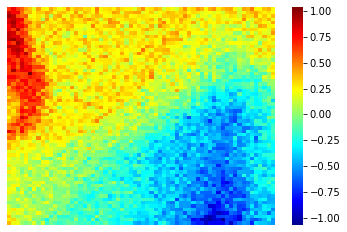

In [4]:
img = llc_io.grab_image(cutout)

ulmo_plotting.show_image(img)

## Velocity Field

In [5]:
ds = xarray.load_dataset( ulmo_io.open( cutout.filename, 'rb') )
ds

<xarray.Dataset>
Dimensions:  (i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_l: 1)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Dimensions without coordinates: k_l
Data variables:
    Theta    (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    U        (j, i_g) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    V        (j_g, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    W        (k_l, j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Salt     (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [6]:
# use existing python module: grab_velocity function in io.py from ulmo.llc
# list containing u_array (64x64) and v_array (64x64)

vel_output = llc_io.grab_velocity(cutout)
index = cutout.pp_idx
vel_output.append(index)

In [7]:
def cutout_show_vel_field( item:tuple ):
    """
    Simple function to create a quiver plot of velocity field in cutout

    Parameters
    ----------
    item : tuple
        field, idx

    Returns
    -------
    matplotlib.Axis: axis containing the plot

    """
    # Unpack
    U_cutout, V_cutout, idx = item

    # Deal with nan
    gdU = np.isfinite(U_cutout)
    gdV = np.isfinite(V_cutout)
    
    # Create masked arrays
    u_field = np.ma.masked_array( U_cutout, mask = ~gdU, dtype = 'float' )
    v_field = np.ma.masked_array( V_cutout, mask = ~gdV, dtype = 'float' )
    
    # Create grid
    x = np.arange(0, 64)
    y = np.arange(0, 64)
    X, Y = np.meshgrid(x, y)
    
    # Color by size
    color = np.sqrt(u_field**2 + v_field**2)
    
    ax = plt.quiver(u_field, v_field, color)
    plt.rcParams["figure.figsize"] = (12,14)
    #plt.axis( 'square' )
    plt.colorbar()
    
    return ax

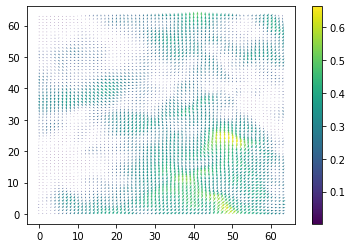

In [8]:
cutout_show_vel_field(vel_output)

## Strain Rate

In [9]:
alpha = kinematics.calc_lateral_strain_rate(vel_output[0], vel_output[1])

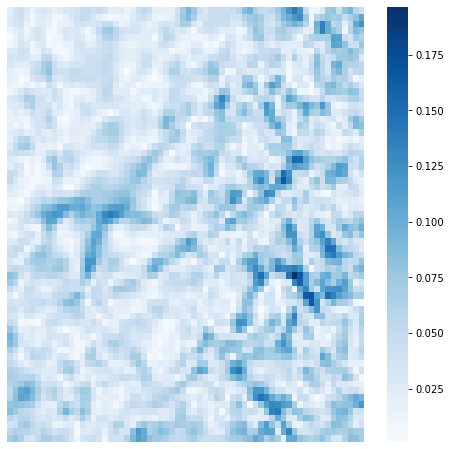

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))

color_map = 'Blues'

g = sns.heatmap(np.flipud(alpha), xticklabels = [], yticklabels = [], cmap=color_map, ax = ax)

plt.show()

## Okubo-Weiss Parameter

In [11]:
W = kinematics.calc_okubo_weiss(vel_output[0], vel_output[1])

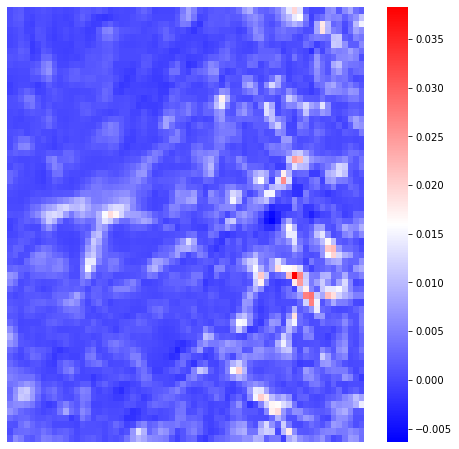

In [12]:
fig1, ax1 = plt.subplots(1, 1, figsize = (8,8))

color_map = 'bwr'

g = sns.heatmap(np.flipud(W), xticklabels = [], yticklabels = [], cmap=color_map, ax = ax1)

plt.show()

## 1. Make a Contour Plot

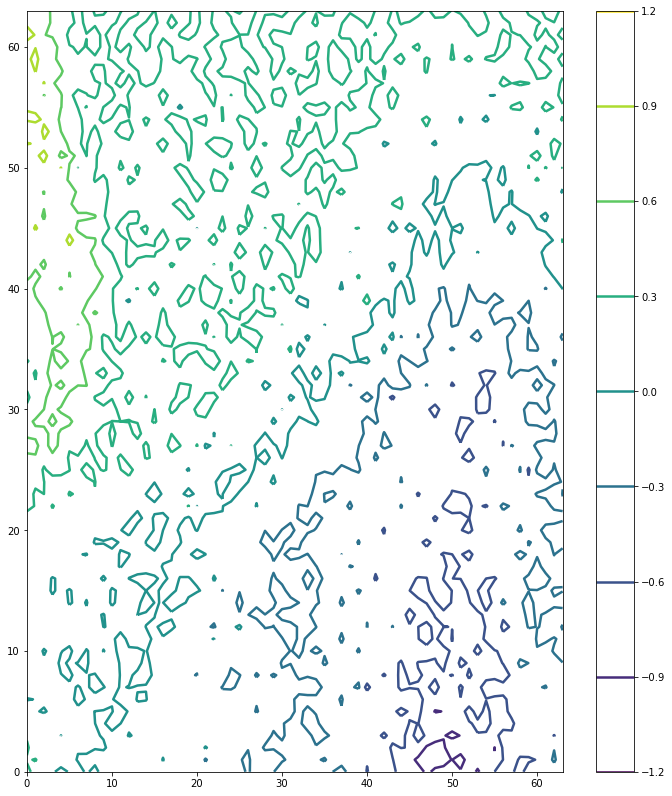

In [13]:
# Try to do 0.5 K contour levels
lvls = int(cutout.DT_abs // 0.3) + 1

#Contour map
cs = plt.contour(img, levels = lvls, linewidths = 2.5)
plt.colorbar()
plt.show()

In [14]:
print(' Number of contour levels: {}'.format( len(cs.levels)) ) 

 Number of contour levels: 9


#### Smoothen contour plot

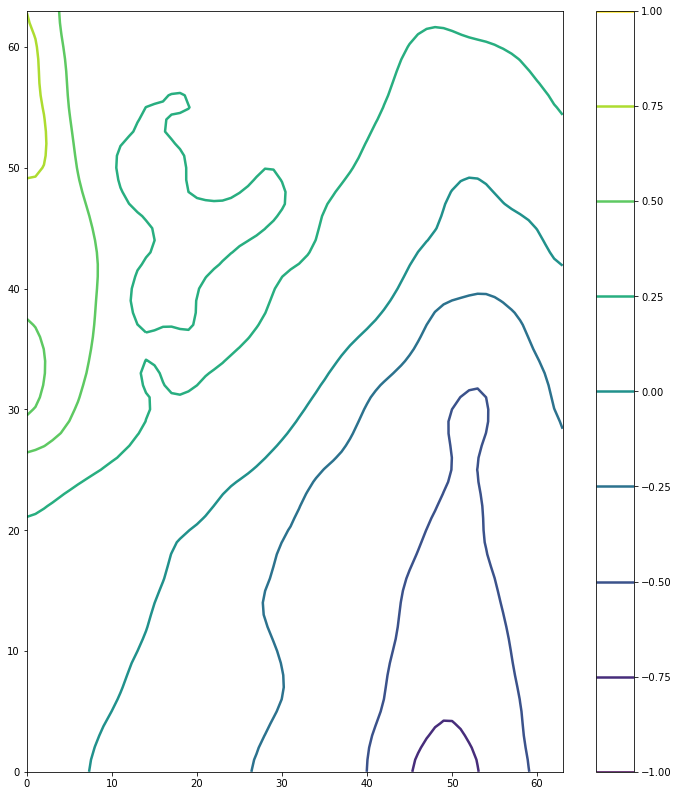

In [15]:
#chosen by appearance, sigma = 2 looks good 
img_g = gaussian_filter(img, sigma = 2)

#Contour map
cs1 = plt.contour(img_g, levels = lvls , linewidths = 2.5)
plt.colorbar()
plt.show()

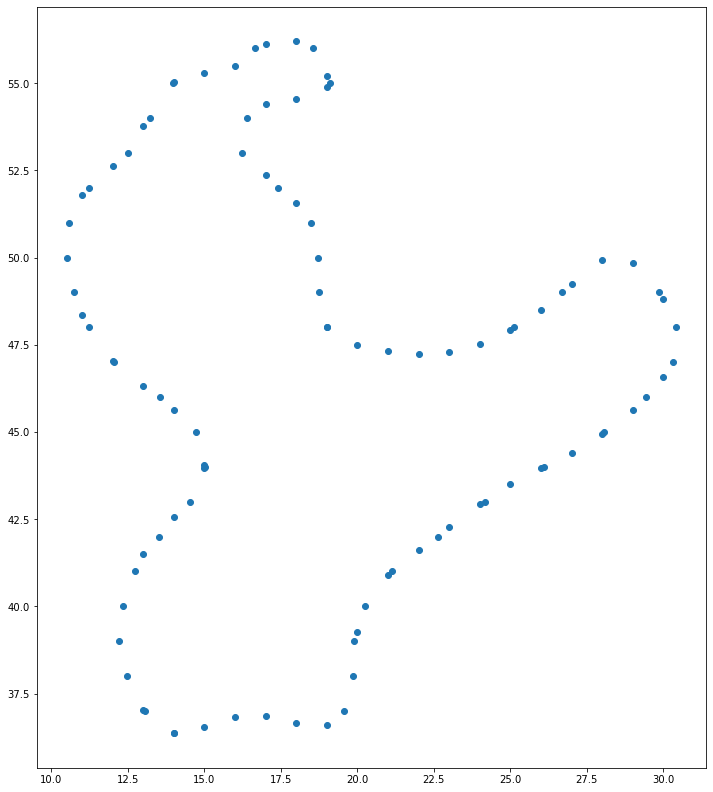

In [16]:
p = cs1.collections[5].get_paths()[1]
d = p.vertices
plt.scatter(d[:,0], d[:,1])

<AxesSubplot:>

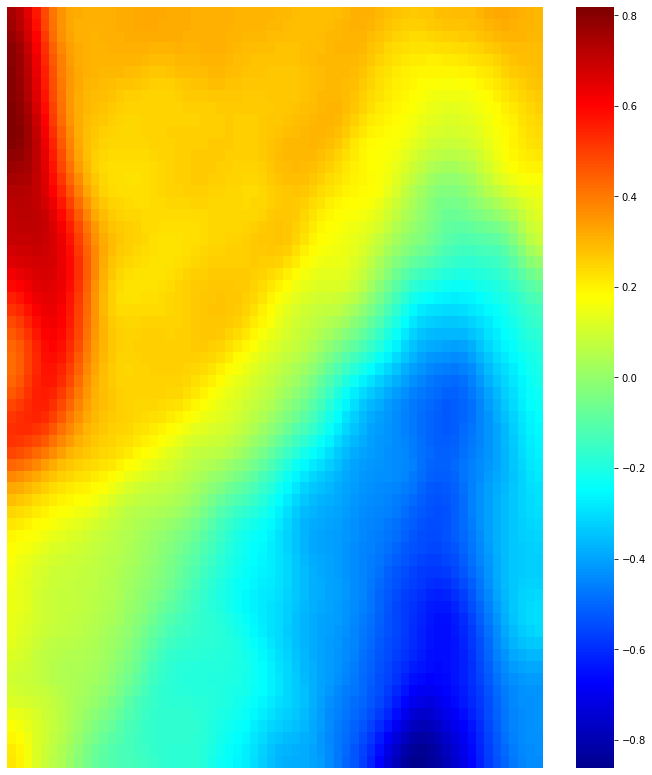

In [17]:
ulmo_plotting.show_image(img_g)

In [18]:
d

array([[14.        , 36.36405276],
       [13.04818678, 37.        ],
       [13.        , 37.02262313],
       [12.46595162, 38.        ],
       [12.19973889, 39.        ],
       [12.33002453, 40.        ],
       [12.73239589, 41.        ],
       [13.        , 41.50974093],
       [13.50330936, 42.        ],
       [14.        , 42.57241572],
       [14.5247649 , 43.        ],
       [15.        , 43.9704283 ],
       [15.01497124, 44.        ],
       [15.        , 44.05640706],
       [14.73247123, 45.        ],
       [14.        , 45.64210868],
       [13.55690914, 46.        ],
       [13.        , 46.32185974],
       [12.0467851 , 47.        ],
       [12.        , 47.03504598],
       [11.23495851, 48.        ],
       [11.        , 48.36045601],
       [10.74208611, 49.        ],
       [10.50755872, 50.        ],
       [10.58098549, 51.        ],
       [11.        , 51.80480598],
       [11.24132284, 52.        ],
       [12.        , 52.61162125],
       [12.5103272 ,

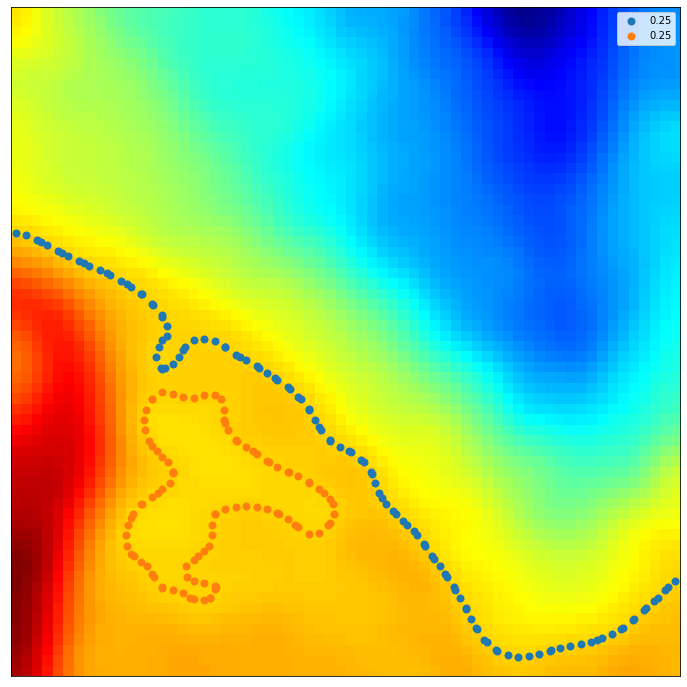

In [19]:
from skimage import measure
test_contours = measure.find_contours(img_g, 0.25)

_, cmap = ulmo_plotting.load_palette()

fig, ax = plt.subplots()
ax.imshow(img_g, cmap=cmap)

for contour in test_contours:
    ax.scatter(contour[:, 1], contour[:, 0], linewidth=2, label ='0.25')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.legend()
plt.show()

In [20]:
test_contours[1][:,1]

array([18.55603035, 19.        , 19.11667861, 19.        , 18.        ,
       17.        , 16.39322667, 16.23933735, 17.        , 17.41646559,
       18.        , 18.48741405, 18.72886763, 18.73182573, 19.        ,
       19.00083585, 20.        , 21.        , 22.        , 23.        ,
       24.        , 25.        , 25.13141618, 26.        , 26.68916465,
       27.        , 28.        , 29.        , 29.8534035 , 30.        ,
       30.40733743, 30.3298358 , 30.        , 29.43456032, 29.        ,
       28.05528233, 28.        , 27.        , 26.09874909, 26.        ,
       25.        , 24.15747495, 24.        , 23.        , 22.62684324,
       22.        , 21.12282871, 21.        , 20.24494787, 20.        ,
       19.90387279, 19.85307962, 19.55432669, 19.        , 18.        ,
       17.        , 16.        , 15.        , 14.        , 13.04818678,
       13.        , 12.46595162, 12.19973889, 12.33002453, 12.73239589,
       13.        , 13.50330936, 14.        , 14.5247649 , 15.  

In [21]:
# determine the spacing between points

c = test_contours[0]



np.linalg.norm(d[0] - d[1])

1.144717128870724

In [22]:
np.linalg.norm(d[3] - d[4])

1.0348281099770715

In [23]:
c[0]

array([21.10305487,  0.        ])

## 2. Calculate curvature of contour lines

In [24]:
from scipy.interpolate import UnivariateSpline
import numpy as np

def curvature_splines(x, y=None, error=0.1):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
         or
         y=None and
         x is a numpy.array(dtype=complex) shape (n_points, )
         In the second case the curve is represented as a np.array
         of complex numbers.
    error : float
        The admisible error when interpolating the splines
    Returns
    -------
    curvature: numpy.array shape (n_points, )
    Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
    but more accurate, especially at the borders.
    """

    # handle list of complex case
    if y is None:
        x, y = x.real, x.imag

    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=3, w=1 / np.sqrt(std))
    fy = UnivariateSpline(t, y, k=3, w=1 / np.sqrt(std))

    xˈ = fx.derivative(1)(t)
    xˈˈ= fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ= fy.derivative(2)(t)
    curvature = (xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 3 / 2)
    return curvature

#### Grab the contours

In [25]:
contours = []

for i in range( len(cs1.levels) -2): 
    
    path = cs1.collections[i + 1].get_paths()[0]
    array = path.vertices
    
    contours.append(array)

contour1, contour2, contour3, contour4, contour5, contour6, contour7  = contours 

#### Curvatures

In [26]:
k1 = curvature_splines(contour1[:, 0], contour1[:, 1])
k2 = curvature_splines(contour2[:, 0], contour2[:, 1])
k3 = curvature_splines(contour3[:, 0], contour3[:, 1])
k4 = curvature_splines(contour4[:, 0], contour4[:, 1])
k5 = curvature_splines(contour5[:, 0], contour5[:, 1])
k6 = curvature_splines(contour6[:, 0], contour6[:, 1])
k7 = curvature_splines(contour7[:, 0], contour7[:, 1])

#### Plot all contours

(0.0, 64.0)

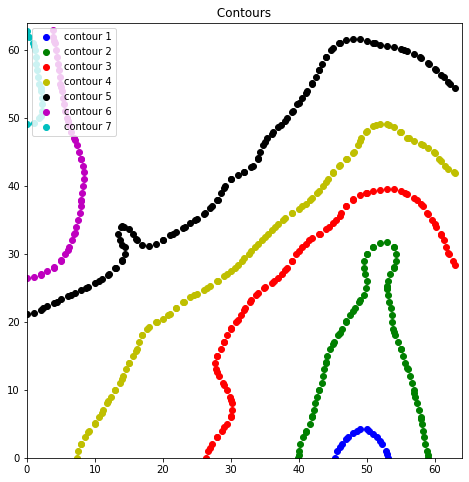

In [27]:
fig2 = plt.figure( figsize = (8, 8))
ax2 = fig2.add_subplot(111)

ax2.scatter(contour1[:,0], contour1[:,1], c='b', label='contour 1')
ax2.scatter(contour2[:,0], contour2[:,1], c='g', label='contour 2')
ax2.scatter(contour3[:,0], contour3[:,1], c='r', label='contour 3')
ax2.scatter(contour4[:,0], contour4[:,1], c='y', label='contour 4')
ax2.scatter(contour5[:,0], contour5[:,1], c='k', label='contour 5')
ax2.scatter(contour6[:,0], contour6[:,1], c='m', label='contour 6')
ax2.scatter(contour7[:,0], contour7[:,1], c='c', label='contour 7')

plt.legend(loc='upper left');
plt.title(' Contours ')
plt.axis('square')
plt.xlim(0, 64)
plt.ylim(0, 64)

## 3. Cut contour lines into segments

#### Find out where to cut up segments: example is contour3

In [28]:
# determine the sign
asign = np.sign(k2)

# determine when does the sign change
signchange = ((np.roll(asign, 1) - asign != 0)).astype(int)

# to avoid starting pt being an inflection pt
signchange[0] = 0   

# indices of array where sign changes
indices = np.where(signchange == 1)[0]
indices

array([12, 27, 37, 53, 67])

#### Slice contour2 into segments

In [29]:
number_of_segments = len(indices) + 1
number_of_segments

6

In [30]:
segments = []
index = 0
for i in range(number_of_segments - 1):
    segments.append( contour2[index : indices[i]] )
    index = indices[i]
    
# last segment
segments.append( contour2[index:] )

In [31]:
segments

[array([[39.96275078,  0.        ],
        [40.        ,  0.4565372 ],
        [40.04741192,  1.        ],
        [40.24378032,  2.        ],
        [40.59401639,  3.        ],
        [41.        ,  3.82841539],
        [41.09077135,  4.        ],
        [41.60265342,  5.        ],
        [41.97802968,  6.        ],
        [42.        ,  6.08925567],
        [42.19790432,  7.        ],
        [42.40494531,  8.        ]]),
 array([[42.67948318,  9.        ],
        [43.        ,  9.92510994],
        [43.02709681, 10.        ],
        [43.36732217, 11.        ],
        [43.61007891, 12.        ],
        [43.783624  , 13.        ],
        [43.9607701 , 14.        ],
        [44.        , 14.15972259],
        [44.21868779, 15.        ],
        [44.62133248, 16.        ],
        [45.        , 16.68883975],
        [45.1930543 , 17.        ],
        [45.81256928, 18.        ],
        [46.        , 18.32121184],
        [46.38365026, 19.        ]]),
 array([[46.94491173, 20

#### Look at sequential segments

(0.0, 64.0)

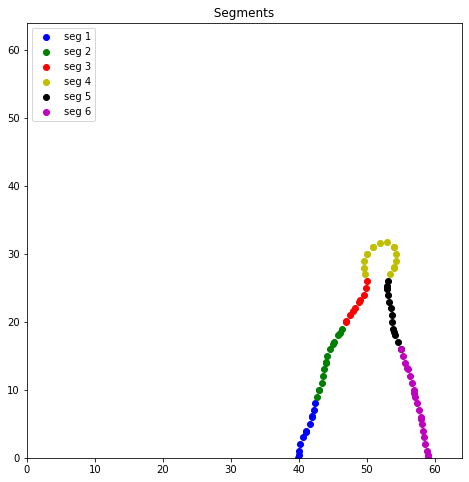

In [32]:
fig3 = plt.figure( figsize = (8, 8))
ax3 = fig3.add_subplot(111)

ax3.scatter(segments[0][:,0], segments[0][:,1], c='b', label='seg 1')
ax3.scatter(segments[1][:,0], segments[1][:,1], c='g', label='seg 2')
ax3.scatter(segments[2][:,0], segments[2][:,1], c='r', label='seg 3')
ax3.scatter(segments[3][:,0], segments[3][:,1], c='y', label='seg 4')
ax3.scatter(segments[4][:,0], segments[4][:,1], c='k', label='seg 5')
ax3.scatter(segments[5][:,0], segments[5][:,1], c='m', label='seg 6')

plt.legend(loc='upper left');
plt.title(' Segments ')
plt.axis('square')
plt.xlim(0, 64)
plt.ylim(0, 64)

## 4. Cluster segments by curvature sign

In [33]:
def cluster( curvature, segments ):
    """ Separate segments into a group with positive curvature and a group with negative curvature 
    
        Params
        ------
        curvature :  list 
        segments : list of segments in contour cuts
    """
    
    # (+) curvature in 1st segment?  
    if curvature[0] > 0: 
        positive = segments[::2]
        negative = segments[1::2]
    else: 
        negative = segments[::2]
        positive = segments[1::2]
        
    return positive, negative
        

In [34]:
pos , neg = cluster(k2, segments)
len(pos)

3

(0.0, 64.0)

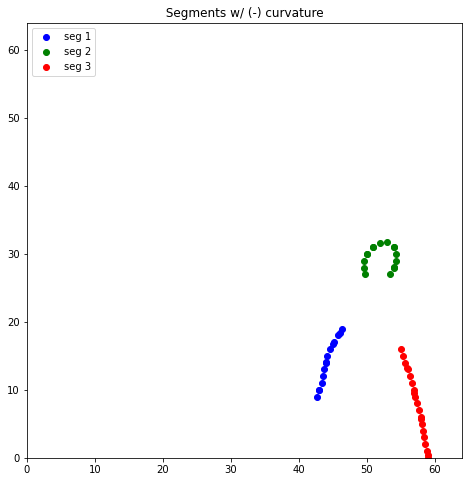

In [35]:
fig3 = plt.figure( figsize = (8, 8))
ax3 = fig3.add_subplot(111)

ax3.scatter(neg[0][:,0], neg[0][:,1], c='b', label='seg 1')
ax3.scatter(neg[1][:,0], neg[1][:,1], c='g', label='seg 2')
ax3.scatter(neg[2][:,0], neg[2][:,1], c='r', label='seg 3')

plt.legend(loc='upper left');
plt.title(' Segments w/ (-) curvature ')
plt.axis('square')
plt.xlim(0, 64)
plt.ylim(0, 64)

# Try another cutout 

In [36]:
low_LL = llc_table.LL < -1000
temp_floor = (llc_table.T90 - llc_table.T10) > 3.1
temp_ceiling = (llc_table.T90 - llc_table.T10) < 3.2

sub_tbl = llc_table[low_LL& temp_floor & temp_ceiling ]

#### Show the image

<AxesSubplot:>

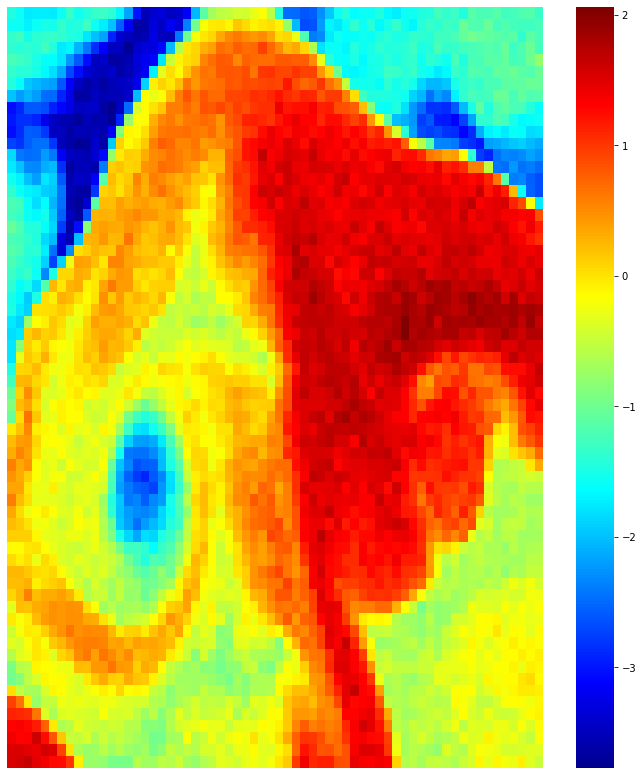

In [37]:
cutout1 = sub_tbl.iloc[1]

img1 = llc_io.grab_image(cutout1)

ulmo_plotting.show_image(img1)

In [42]:
cutout1

modis_lat                                                   38.159103
modis_lon                                                   156.69719
modis_col                                                         197
modis_datetime                                    2012-03-30 15:10:00
modis_LL                                                    89.354431
modis_row                                                         912
clear_fraction                                               0.000366
mean_temperature                                            12.934269
Tmin                                                            9.331
Tmax                                                           14.783
T90                                                            14.439
T10                                                            11.304
modis_filename                   AQUA_MODIS.20120330T151008.L2.SST.nc
modis_UID                                         1333128159133669719
pp_file             

## Contour Plot

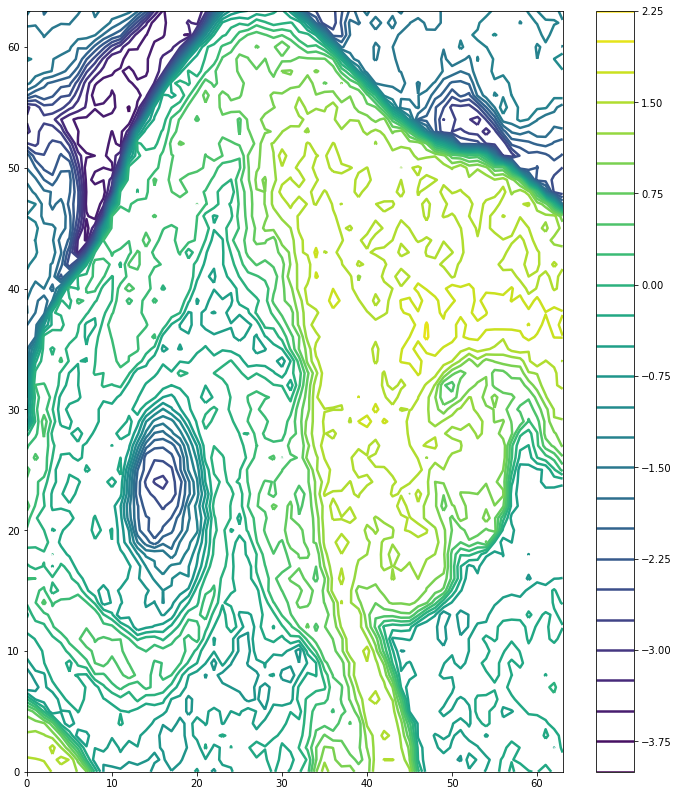

In [38]:
#Find number of contour levels to draw
lvls1 = int(cutout1.DT_abs // 0.2) + 1

#Contour map
plt.contour(img1, levels = lvls1, linewidths = 2.5)
plt.colorbar()
plt.show()

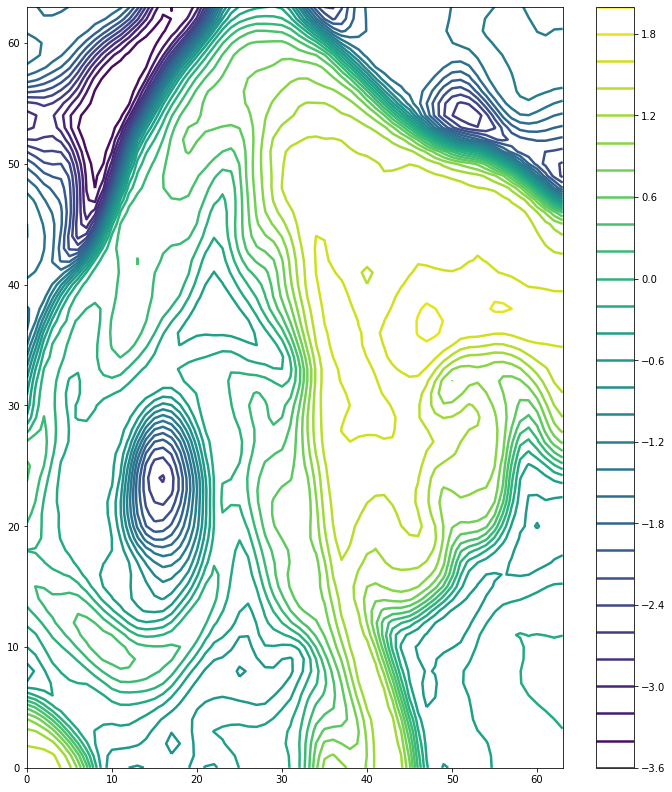

In [39]:
#chosen by appearance, sigma = 1 looks good 
img_g1 = gaussian_filter(img1, sigma = 1)

#Contour map
cs2 = plt.contour(img_g1, levels = lvls1, linewidths = 2.5)
plt.colorbar()
plt.show()

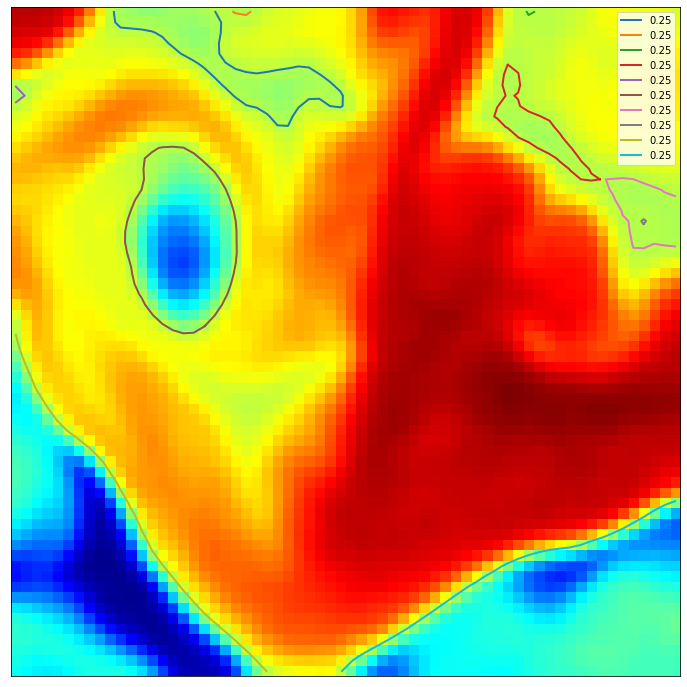

In [43]:
# can pinpoint a specific contour level
from skimage import measure
test_contours1 = measure.find_contours(img_g1, -0.6)

_, cmap = ulmo_plotting.load_palette()

fig, ax = plt.subplots()
ax.imshow(img_g1, cmap=cmap)

for contour in test_contours1:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, label ='0.25')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.legend()
plt.show()

In [49]:
ds1 = xarray.load_dataset( ulmo_io.open( cutout1.filename, 'rb') )
ds1

<xarray.Dataset>
Dimensions:  (i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_l: 1)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Dimensions without coordinates: k_l
Data variables:
    Theta    (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    U        (j, i_g) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    V        (j_g, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    W        (k_l, j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Salt     (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

## Velocity Field

In [50]:
vel_output1 = llc_io.grab_velocity(cutout1)
index1 = cutout1.pp_idx
vel_output1.append(index1)

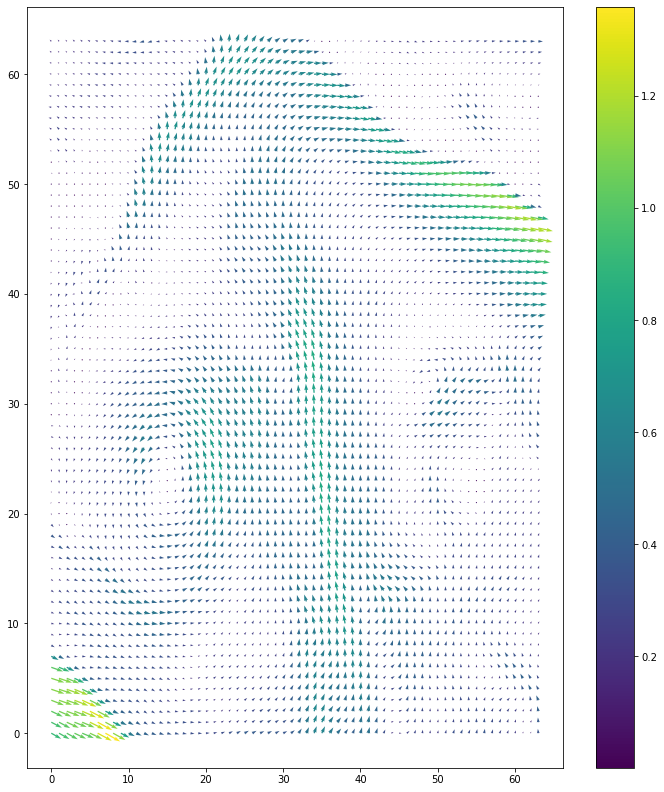

In [51]:
cutout_show_vel_field( vel_output1 )

## Contours

In [139]:
Contours = {}
count = 0

for i in range( len(cs2.levels) -2): 
    
    paths = cs2.collections[i + 1].get_paths()
    
    for j in range( len(paths)):
        # create a dictionary
        count += 1
        Contours[count] = {}
        
        # continous points
        array = paths[j].vertices
        Contours[count]['array'] = array
        
        #curvature
        curvature = curvature_splines(array[:, 0], array[:, 1])
        Contours[count]['curvature'] = curvature
        
        # determine when does the sign change
        asign = np.sign(curvature)
        signchange = ((np.roll(asign, 1) - asign != 0)).astype(int)
        signchange[0] = 0   
        indices = np.where(signchange == 1)[0]
        Contours[count]['indices'] = indices
        
        # create two nested dicts that contain the segments w/ positive and negative curvature
        number_of_segments = len(Contours[count]['indices']) + 1
        Contours[count]['positive'] = {}
        Contours[count]['negative'] = {}
        
        # no change in curvature sign in entire contour
        if number_of_segments ==1: 
            
            if curvature[0] > 0:     
                Contours[count]['positive'][1] = array
            else: 
                Contours[count]['negative'][1] = array
                
            
        # contour switches curvature sign   
        else: 
            
            idx0 = 0
            odd = 1
            even = 1
            for k in range(number_of_segments - 1):
                idx1 = indices[k]
                
                # depending on 1st segment, even or odd is (+) curvature and vice versa
                # k%2 != 0 (odd) and k%2 == 0 (even)
                if curvature[0] > 0 and (k+1)%2 != 0:
                    Contours[count]['positive'][odd] = array[idx0 : idx1]
                    odd += 1
                if curvature[0] > 0 and (k+1)%2 == 0:
                    Contours[count]['negative'][even] = array[idx0 : idx1]
                    even += 1
                if curvature[0] < 0 and (k+1)%2 == 0:
                    Contours[count]['positive'][even] = array[idx0 : idx1]
                    even += 1
                if curvature[0] < 0 and (k+1)%2 != 0: 
                    Contours[count]['negative'][odd] = array[idx0 : idx1]
                    odd += 1
                    
                idx0 = idx1
            
                # last segment
                if k == number_of_segments -2 and k >0:
                    
                    # assign the last segment
                    # determine if odd or even
                    if number_of_segments %2 == 0:
                        if curvature[0] > 0:
                            Contours[count]['negative'][even] = array[idx0:]
                        else: 
                            Contours[count]['positive'][even] = array[idx0:]
                        
                    else: 
                        if curvature[0] < 0:
                            Contours[count]['positive'][odd] = array[idx0:]
                        else: 
                            Contours[count]['negative'][odd] = array[idx0:]
            

In [140]:
3%2 != 0

True

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

(0.0, 64.0)

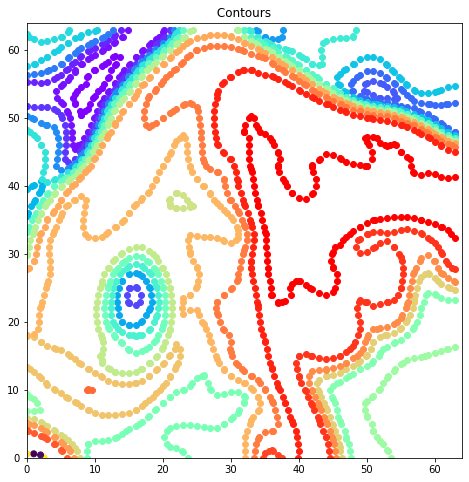

In [141]:
# calculate curvature and plot contour lines
from matplotlib.pyplot import cm

fig4 = plt.figure( figsize = (8, 8))
ax4 = fig4.add_subplot(111)

color=cm.rainbow(np.linspace(0,1, len(Contours)))

for m in range( len(Contours) ):
    
    ax4.scatter(Contours[m+1]['array'][:,0], Contours[m+1]['array'][:,1], c= color[m], label='contour {}'.format(m + 1) )

#plt.legend(loc='upper left');
plt.title(' Contours ')
plt.axis('square')
plt.xlim(0, 64)
plt.ylim(0, 64)

## Visualize the Segment Clusters

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 64.0)

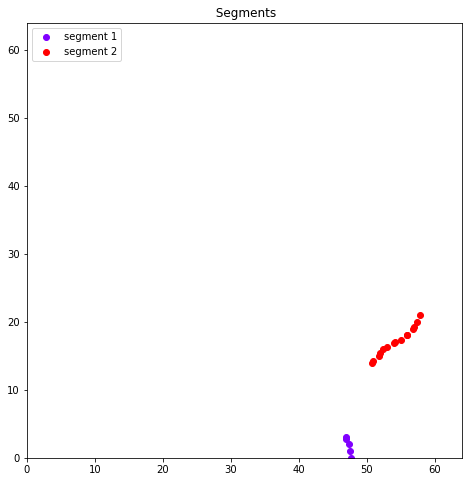

In [170]:
# plot the segments for one contour line
n = 23
o = len(Contours[n]['positive'])

fig5 = plt.figure( figsize = (8, 8))
ax5 = fig5.add_subplot(111)

color=cm.rainbow(np.linspace(0,1, o))

for m in range( o ):
    ax5.scatter(Contours[n]['positive'][m+1][:,0], Contours[n]['positive'][m+1][:,1], c= color[m], label='segment {}'.format(m + 1) )

plt.legend(loc='upper left');
plt.title(' Segments')
plt.axis('square')
plt.xlim(0, 64)
plt.ylim(0, 64)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

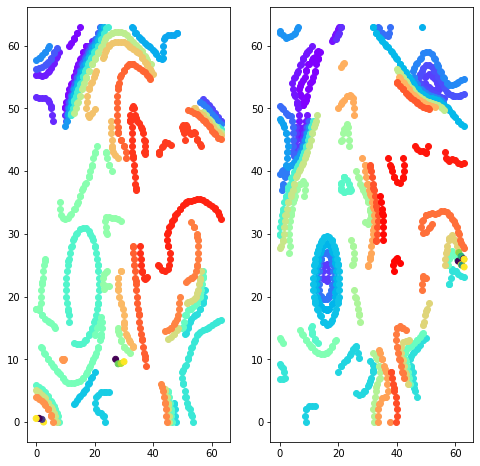

In [176]:
fig6, [ax1, ax2] = plt.subplots(1, 2, figsize = (8,8) )

m = 0
color= cm.rainbow(np.linspace(0,1, 3*len(Contours))) 

for i in range(len(Contours)):
    
    for j in range( len(Contours[i+1]['positive'])):
        ax1.scatter(Contours[i+1]['positive'][j+1][:,0] , Contours[i+1]['positive'][j+1][:,1], c=color[m])
        m+=1
        
    for k in range( len(Contours[i+1]['negative'])):
        ax2.scatter(Contours[i+1]['negative'][k+1][:,0] , Contours[i+1]['negative'][k+1][:,1], c=color[m])
        m+=1

In [169]:
color= cm.rainbow(np.linspace(0,1, 3*len(Contours)))
color[1]

array([0.49215686, 0.01231966, 0.99998103, 1.        ])

In [156]:
Contours[2]['positive']

{1: array([[17.0829302 , 60.        ],
        [17.        , 59.93052609],
        [16.04321292, 59.        ],
        [16.        , 58.95487014],
        [15.16737166, 58.        ],
        [15.        , 57.79618255],
        [14.33600872, 57.        ],
        [14.        , 56.54700262],
        [13.562284  , 56.        ],
        [13.        , 55.14309368],
        [12.89369685, 55.        ],
        [12.13152723, 54.        ],
        [12.        , 53.81515658],
        [11.33873862, 53.        ],
        [11.        , 52.3283959 ],
        [10.7649435 , 52.        ],
        [10.26505024, 51.        ],
        [10.        , 50.22401329],
        [ 9.8723072 , 50.        ]]),
 2: array([[11.14632619, 60.        ],
        [12.        , 60.45748104],
        [12.75942616, 61.        ],
        [13.        , 61.15625868],
        [14.        , 61.9285006 ],
        [14.07876454, 62.        ],
        [14.822185  , 63.        ]])}

In [145]:
Contours[23]['negative']

{1: array([[46.7447204 ,  4.        ],
        [46.27262431,  5.        ],
        [46.        ,  5.40252597],
        [45.81068248,  6.        ],
        [45.5992951 ,  7.        ],
        [45.40530287,  8.        ],
        [45.        ,  8.64102211],
        [44.87473902,  9.        ],
        [44.55689823, 10.        ],
        [45.        , 10.51787811],
        [45.62235486, 11.        ],
        [46.        , 11.13363089],
        [47.        , 11.70925043],
        [47.32507677, 12.        ],
        [48.        , 12.32015483],
        [48.98837746, 13.        ],
        [49.        , 13.00602744],
        [50.        , 13.47001036]]),
 2: array([[57.99581149, 22.        ],
        [58.        , 22.02910802],
        [58.36550363, 23.        ],
        [58.75690105, 24.        ],
        [59.        , 24.32588436],
        [60.        , 24.10734311],
        [60.22464177, 24.        ],
        [61.        , 23.51104048],
        [62.        , 23.23537933],
        [63.        

## Convex Hull

In [185]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d   
points= Contours[44]['segments'][1] # 30 random points in 2-D
hull = ConvexHull(points)

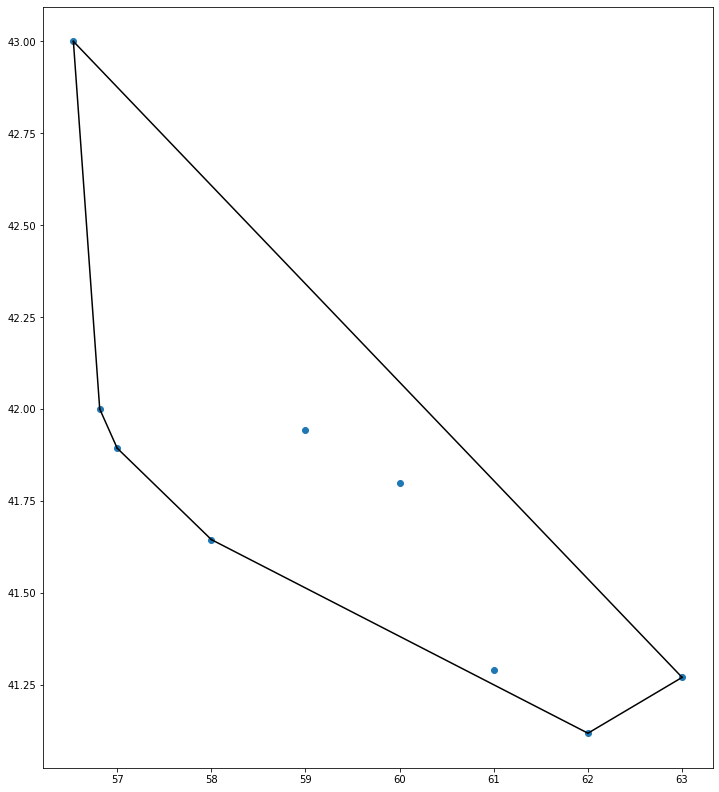

In [186]:
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [191]:
ConvexHull?

Init signature: ConvexHull(points, incremental=False, qhull_options=None)
Docstring:     
ConvexHull(points, incremental=False, qhull_options=None)

Convex hulls in N dimensions.

.. versionadded:: 0.12.0

Parameters
----------
points : ndarray of floats, shape (npoints, ndim)
    Coordinates of points to construct a convex hull from
incremental : bool, optional
    Allow adding new points incrementally. This takes up some additional
    resources.
qhull_options : str, optional
    Additional options to pass to Qhull. See Qhull manual
    for details. (Default: "Qx" for ndim > 4 and "" otherwise)
    Option "Qt" is always enabled.

Attributes
----------
points : ndarray of double, shape (npoints, ndim)
    Coordinates of input points.
vertices : ndarray of ints, shape (nvertices,)
    Indices of points forming the vertices of the convex hull.
    For 2-D convex hulls, the vertices are in counterclockwise order.
    For other dimensions, they are in input order.
simplices : ndarray of i